In [1]:
import math
import json
import random
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
from collections import Counter 
import matplotlib.ticker as ticker


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
oc43a_aamuts_file = '../santa-sim_oc43a/santa-sim_oc43a-spike/oc43a_emperical_spike/results/aa_muts_emperical.json'

with open(oc43a_aamuts_file) as json_handle:
    aa_mut_dict = json.load(json_handle)

##store all muts in S1
oc43a_s1_muts = []    

for node, node_dict in aa_mut_dict['nodes'].items():
    if 'S1' in node_dict['aa_muts'].keys():
        oc43a_s1_muts+=node_dict['aa_muts']['S1']

##tally all muts in S1
##by mut
oc43a_s1_aamuts_count = Counter(oc43a_s1_muts)

#by site
oc43a_s1_mut_sites = [x[1:-1] for x in oc43a_s1_muts]
oc43a_s1_sites_count = Counter(oc43a_s1_mut_sites)

In [3]:
def count_muts_by_site(cov, kind, lineage=None):
    
    reference_file = '../'+str(cov)+'/config/'+str(cov)+'_spike_reference.gb'
    for seq_record in SeqIO.parse(reference_file, "genbank"):
        spike_len = len(seq_record)
        for feature in seq_record.features:
            if feature.type == 'CDS':
                if feature.qualifiers['gene'] == ['s1']:
                    s1_nt_loc = [int(feature.location.start), int(feature.location.end)]
                    s1_aa_loc = [int(s1_nt_loc[0]/3 +1), int(s1_nt_loc[1]/3)]
                if feature.qualifiers['gene'] == ['s2']:
                    s2_nt_loc = [int(feature.location.start), int(feature.location.end)]
                    s2_aa_loc = [int(s2_nt_loc[0]/3 +1), int(s2_nt_loc[1]/3)]
    
    if kind == 'aa':
        muts_file = '../'+str(cov)+'/results/aa_muts_'+str(cov)+'_spike.json'
        mut_key = 'aa_muts'
    elif kind == 'nt':
        muts_file = '../'+str(cov)+'/results/nt_muts_'+str(cov)+'_spike.json'
        mut_key = 'muts'
    
    if cov != '229e':
        clades_file = '../'+str(cov)+'/results/clades_spike.json'
        with open(clades_file) as clade_handle:
            clade_dict = json.load(clade_handle)
    
        #find nodes within specified lineage
        lineage_nodes = []
        for node, node_dict in clade_dict['nodes'].items():
            if node_dict['clade_membership'] == lineage:
                lineage_nodes.append(node)
    
    with open(muts_file) as json_handle:
        mut_dict = json.load(json_handle)

    ##store all muts in spike
    muts = []    

    for node, node_dict in mut_dict['nodes'].items():
        if lineage!= None:
            if node in lineage_nodes:
                if kind == 'aa':
                    if 'spike' in node_dict['aa_muts'].keys():
                        muts+=node_dict['aa_muts']['spike']
                elif kind == 'nt':
                    muts+=node_dict['muts']
                
        elif lineage == None:
            if kind == 'aa':
                if 'spike' in node_dict['aa_muts'].keys():
                    muts+=node_dict['aa_muts']['spike']
            elif kind == 'nt':
                muts+=node_dict['muts']
    ##tally all muts in spike
    ##by mut
    muts_count = Counter(muts)

    #by site
    mut_sites = [int(x[1:-1]) for x in muts]
    sites_count = Counter(mut_sites)
    
    #add zeros for all unmutated sites
    if kind == 'nt':
        for pos in range(spike_len):
            if pos not in sites_count.keys():
                sites_count[pos] = 0
    elif kind == 'aa':
        for pos in range(int(spike_len/3)):
            if pos not in sites_count.keys():
                sites_count[pos] = 0
                
    #count mutations in 20 nt window
    if kind == 'aa':
        s1_muts_per_window = count_muts_per_window(s1_aa_loc, sites_count)
        s2_muts_per_window = count_muts_per_window(s2_aa_loc, sites_count)
        s1_avg_muts = average_num_muts_per_site(s1_aa_loc, sites_count)
        s2_avg_muts = average_num_muts_per_site(s2_aa_loc, sites_count)
    if kind == 'nt':
        s1_muts_per_window = count_muts_per_window(s1_nt_loc, sites_count)
        s2_muts_per_window = count_muts_per_window(s2_nt_loc, sites_count)
        s1_avg_muts = average_num_muts_per_site(s1_nt_loc, sites_count)
        s2_avg_muts = average_num_muts_per_site(s2_nt_loc, sites_count)
    
    return muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts

In [11]:
#sites that mutate the most
muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site('oc43', 'aa', 'A')
for site, count in sites_count.items():
    if count>5:
        print(site)
        
# muts_count, sites_count, s1_muts_per_window, s2_muts_per_window = count_muts_by_site('oc43', 'aa', 'B')
# for site, count in sites_count.items():
#     if count>2:
#         print(site)

26
262
35
525
192
759


In [9]:
#average number of muts per site in S1, S2
def average_num_muts_per_site(loc, sites_count):
    total_muts = 0
    for site, count in sites_count.items():
        if site in range(loc[0], loc[1]):
            total_muts+=count
    region_len = len(range(loc[0], loc[1]))
    
    avg_muts_per_site = total_muts/region_len
    
    return avg_muts_per_site


In [8]:
def count_muts_per_window(loc, sites_count):
    region_length = loc[1]-loc[0]
    windows = []
    for i in range(loc[0], loc[1], 20):
        if i+20>loc[1]:
            window = range(i, loc[1])
        else:
            window = range(i,i + 20)
        windows.append(window)
    
    window_counts = {}
    for window in windows:

        window_count = 0
        for site, count in sites_count.items():
            if site in window:
                window_count+=count
        window_counts[window[0]] = window_count
        
    return window_counts
    

In [ ]:
### Not all CoV Spikes are the same length, give each residue a relative position along spike? Or plot CoVs separately?
### Add zero counts for unmutated sites


In [20]:
def plot_muts_by_pos_separate_axes(covs, kind, filename=None):
    
    #make dataframe of mutation counts at all sites for all CoVs
    to_plot = []
    
    #positions of S1 and S2 for each CoV
    domain_positions = {}
    
    for cov in covs:
        reference_file = '../'+str(cov)+'/config/'+str(cov)+'_spike_reference.gb'
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            spike_len = len(seq_record)
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['gene'][0] == 's1':
                        domain_positions[cov] = {'s1_start': feature.location.start, 
                                                 's1_end': feature.location.end, 'spike_len': spike_len}
        
        if cov == '229e':
            muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind)
            for site, count in sites_count.items():
                to_plot.append({'cov' : cov, 'cov_lineage' : cov, 'position': int(site), 
                                'count': int(count), 'type_of_mut': kind})
        else:
            lineages = ['A', 'B']
            for lineage in lineages:
                muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind, lineage=lineage)
                for site, count in sites_count.items():
                    to_plot.append({'cov' : cov, 'cov_lineage' : cov+lineage, 'position': int(site), 
                                    'count': int(count), 'type_of_mut': kind})
    
    to_plot_df = pd.DataFrame(to_plot)
    
    color_map = {'oc43A': '#CB4335', 'oc43B':'#FF9A00',  '229e': '#2E86C1', 
                 'nl63A': '#009888', 'nl63B': '#87C735', 'hku1A': '#7c5295', 'hku1B': '#b491c8'}    
    
    
    fig, axes = plt.subplots(4, 1, figsize=(14,14), sharex=False, sharey=True)
    
    for ax in range(len(axes)):
        sns.scatterplot(x="position", y="count", hue='cov_lineage', linewidth=0.3,
                      palette=color_map, data=to_plot_df[to_plot_df['cov']==covs[ax]], ax=axes[ax])
        
        if kind == 'aa':
            axes[ax].set(xlabel="", ylabel="amino acid substitutions per site")
        elif kind == 'nt':
            axes[ax].set(xlabel="", ylabel="nucleotide mutations per site")
        
        trans = axes[ax].get_xaxis_transform()
        if kind == 'nt':
            axes[ax].annotate('S1', xy=(int(domain_positions[covs[ax]]['s1_start']), -.18), 
                              fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].plot([int(domain_positions[covs[ax]]['s1_start']),int(domain_positions[covs[ax]]['s1_end'])],
                          [-.14,-.14], color="#878787", linewidth=10, transform=trans, clip_on=False)
        elif kind == 'aa':
            axes[ax].annotate('S1', xy=((int(domain_positions[covs[ax]]['s1_end'])/3/2), -.20), 
                  fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].annotate('S2', xy=((((int(domain_positions[covs[ax]]['spike_len'])-int(domain_positions[covs[ax]]['s1_end']))/3/2)+int(domain_positions[covs[ax]]['s1_end'])/3), -.20), 
                              fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].plot([((int(domain_positions[covs[ax]]['s1_end'])/3)+3),
                           (int(domain_positions[covs[ax]]['spike_len'])/3)],[-.16,-.16], 
                          color="#a5a5a5", linewidth=6, transform=trans, clip_on=False)
            axes[ax].plot([(int(domain_positions[covs[ax]]['s1_start'])/3),
                           (int(domain_positions[covs[ax]]['s1_end'])/3)],[-.16,-.16], 
                          color="#878787", linewidth=10, transform=trans, clip_on=False)

    fig.tight_layout(pad=3.0)
    
    if filename:
        fig.savefig(filename, dpi=300)

In [21]:
def plot_muts_by_window_separate_axes(covs, kind, filename=None):
    
    #make dataframe of mutation counts at all sites for all CoVs
    to_plot = []
    
    #positions of S1 and S2 for each CoV
    domain_positions = {}
    
    for cov in covs:
        reference_file = '../'+str(cov)+'/config/'+str(cov)+'_spike_reference.gb'
        for seq_record in SeqIO.parse(reference_file, "genbank"):
            spike_len = len(seq_record)
            for feature in seq_record.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['gene'][0] == 's1':
                        domain_positions[cov] = {'s1_start': feature.location.start, 
                                                 's1_end': feature.location.end, 'spike_len': spike_len}
        
        if cov == '229e':
            muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind)
            for window_start, count in s1_muts_per_window.items():
                to_plot.append({'cov' : cov, 'cov_lineage' : cov, 'position': int(window_start), 
                                'count': int(count), 'type_of_mut': kind, 'region': 's1'})
            for window_start, count in s2_muts_per_window.items():
                to_plot.append({'cov' : cov, 'cov_lineage' : cov, 'position': int(window_start), 
                                'count': int(count), 'type_of_mut': kind, 'region': 's2'})
        else:
            lineages = ['A', 'B']
            for lineage in lineages:
                muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind, lineage=lineage)
                for window_start, count in s1_muts_per_window.items():
                    to_plot.append({'cov' : cov, 'cov_lineage' : cov+lineage, 'position': int(window_start), 
                                    'count': int(count), 'type_of_mut': kind, 'region': 's1'})
                for window_start, count in s2_muts_per_window.items():
                    to_plot.append({'cov' : cov, 'cov_lineage' : cov+lineage, 'position': int(window_start), 
                                    'count': int(count), 'type_of_mut': kind, 'region': 's2'})
    
    to_plot_df = pd.DataFrame(to_plot)
    
    color_map = {'oc43A': '#CB4335', 'oc43B':'#FF9A00',  '229e': '#2E86C1', 
                 'nl63A': '#009888', 'nl63B': '#87C735', 'hku1A': '#7c5295', 'hku1B': '#b491c8'}    
    
    
    fig, axes = plt.subplots(4, 1, figsize=(14,14), sharex=False, sharey=True)
    
    for ax in range(len(axes)):
        sns.scatterplot(x="position", y="count", hue='cov_lineage', linewidth=0.3,
                      palette=color_map, data=to_plot_df[to_plot_df['cov']==covs[ax]], ax=axes[ax])
        
        if kind == 'aa':
            axes[ax].set(xlabel="", ylabel="amino acid substitutions per site")
        elif kind == 'nt':
            axes[ax].set(xlabel="", ylabel="nucleotide mutations per site")
        
        trans = axes[ax].get_xaxis_transform()
        if kind == 'nt':
            axes[ax].annotate('S1', xy=(int(domain_positions[covs[ax]]['s1_start']), -.18), 
                              fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].plot([int(domain_positions[covs[ax]]['s1_start']),int(domain_positions[covs[ax]]['s1_end'])],
                          [-.14,-.14], color="#878787", linewidth=10, transform=trans, clip_on=False)
        elif kind == 'aa':
            axes[ax].annotate('S1', xy=((int(domain_positions[covs[ax]]['s1_end'])/3/2), -.20), 
                  fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].annotate('S2', xy=((((int(domain_positions[covs[ax]]['spike_len'])-int(domain_positions[covs[ax]]['s1_end']))/3/2)+int(domain_positions[covs[ax]]['s1_end'])/3), -.20), 
                              fontsize=14, xycoords=trans, ha="center", va="top")
            axes[ax].plot([((int(domain_positions[covs[ax]]['s1_end'])/3)+3),
                           (int(domain_positions[covs[ax]]['spike_len'])/3)],[-.16,-.16], 
                          color="#a5a5a5", linewidth=6, transform=trans, clip_on=False)
            axes[ax].plot([(int(domain_positions[covs[ax]]['s1_start'])/3),
                           (int(domain_positions[covs[ax]]['s1_end'])/3)],[-.16,-.16], 
                          color="#878787", linewidth=10, transform=trans, clip_on=False)

    fig.tight_layout(pad=3.0)
    
    if filename:
        fig.savefig(filename, dpi=300)

In [ ]:
#average number of mutations for S1 and S2 of each CoV
def average_muts_per_site_s1_s2(covs, kind):
    
    to_plot = []
    
    for cov in covs:
        if cov == '229e':
            muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind)
            to_plot.append({'cov' : cov, 'cov_lineage' : cov, 'type_of_mut': kind, 
                            's1_avg_muts': s1_avg_muts, 's2_avg_muts': s2_avg_muts})

        else:
            lineages = ['A', 'B']
            for lineage in lineages:
                muts_count, sites_count, s1_muts_per_window, s2_muts_per_window, s1_avg_muts, s2_avg_muts = count_muts_by_site(cov, kind, lineage=lineage)
                to_plot.append({'cov' : cov, 'cov_lineage' : cov+lineage, 'type_of_mut': kind, 
                                's1_avg_muts': s1_avg_muts, 's2_avg_muts': s2_avg_muts})
                
    to_plot_df = pd.DataFrame(to_plot)
    print(to_plot_df)

In [274]:
average_muts_per_site_s1_s2(['oc43', '229e', 'hku1', 'nl63'], 'aa')

    cov cov_lineage type_of_mut  s1_avg_muts  s2_avg_muts
0  oc43       oc43A          aa     0.303191     0.095798
1  oc43       oc43B          aa     0.170213     0.067227
2  229e        229e          aa     0.182692     0.032967
3  hku1       hku1A          aa     0.157965     0.075503
4  hku1       hku1B          aa     0.000000     0.000000
5  nl63       nl63A          aa     0.077364     0.050078
6  nl63       nl63B          aa     0.022923     0.028169


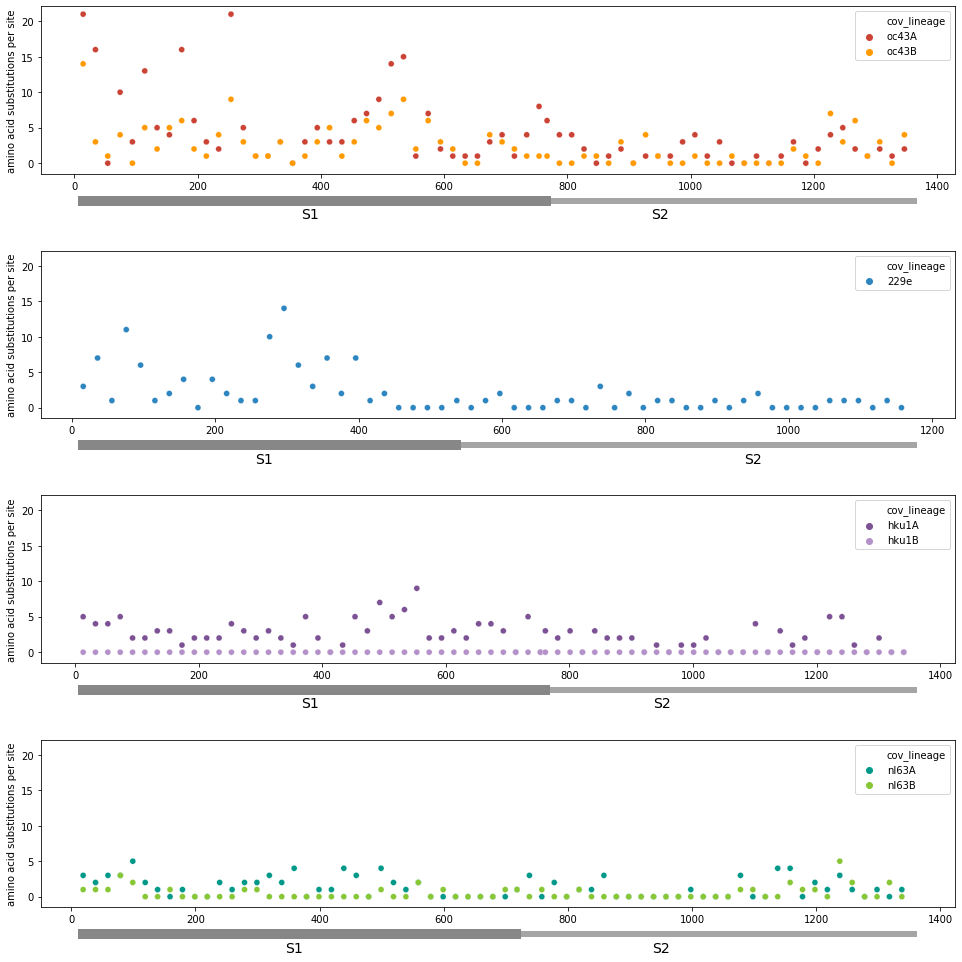

In [249]:
plot_muts_by_window_separate_axes(['oc43', '229e', 'hku1', 'nl63'], 'aa',  filename='spike_mutations_20nt_windows.png')

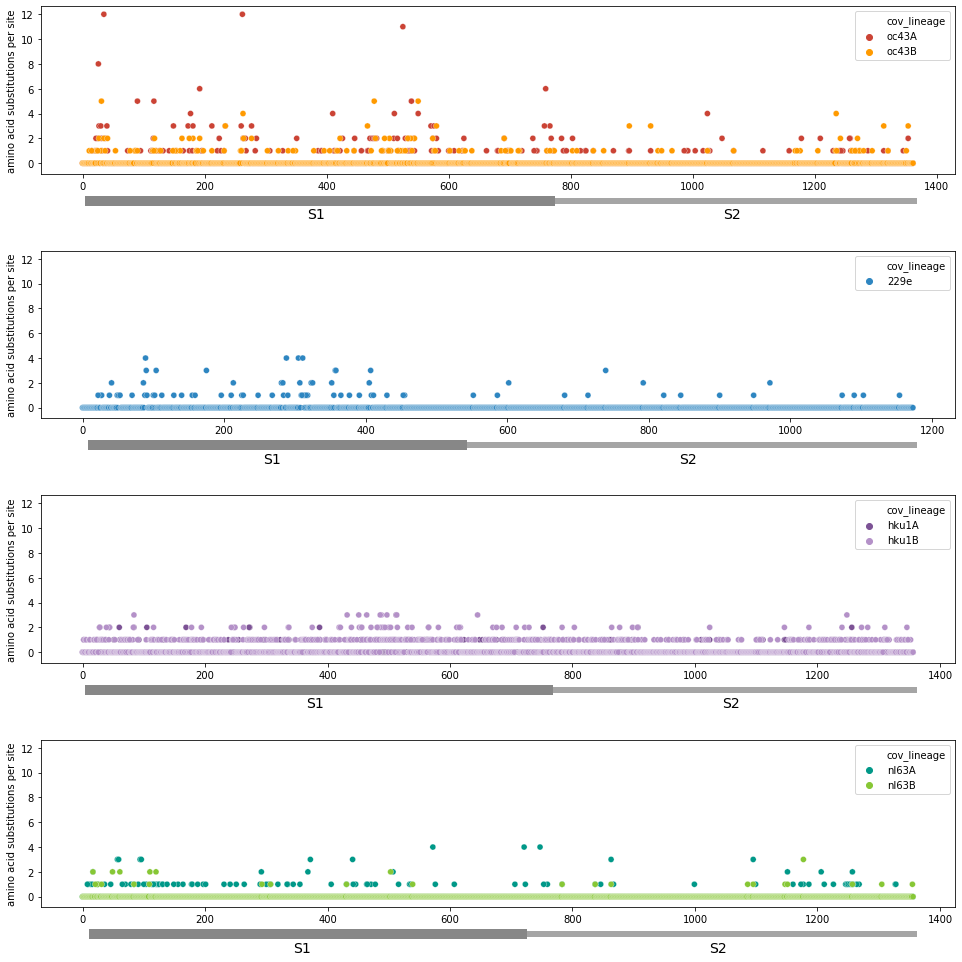

In [23]:
plot_muts_by_pos_separate_axes(['oc43', '229e', 'hku1', 'nl63'], 'aa', filename='spike_mutations_separate_plots_sep11.png')

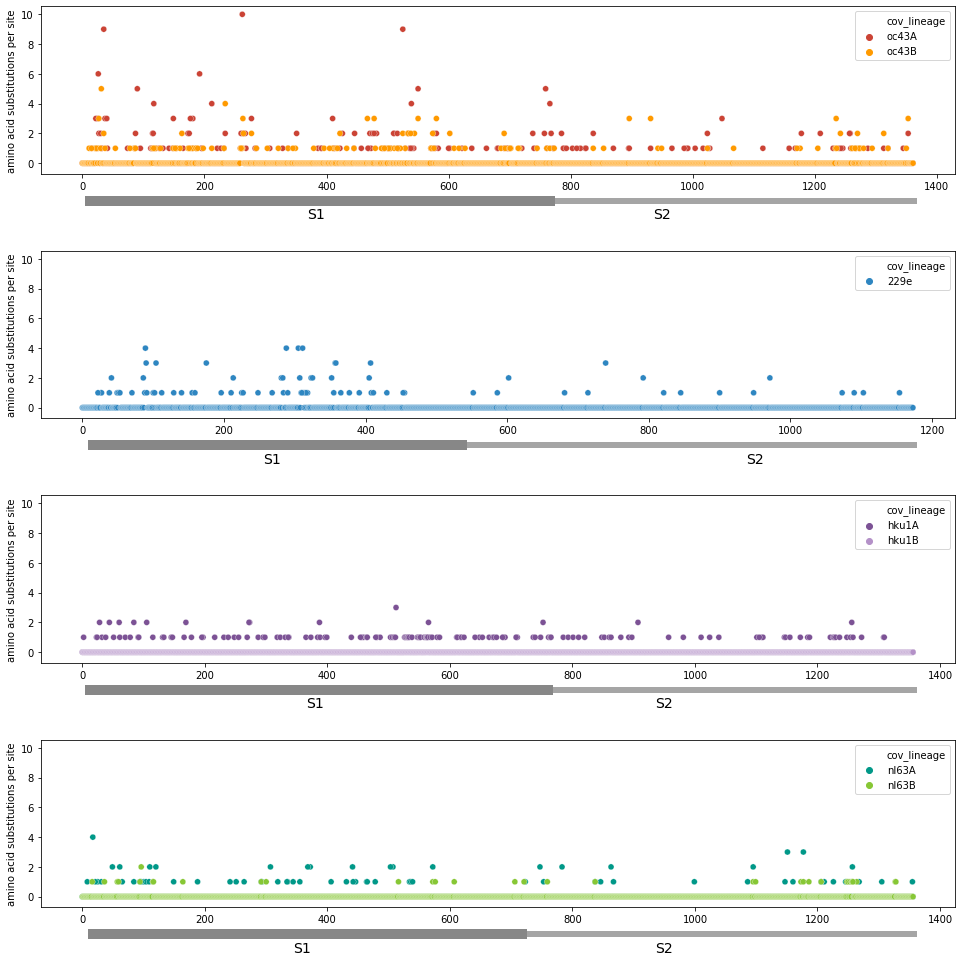

In [121]:
plot_muts_by_pos_separate_axes(['oc43', '229e', 'hku1', 'nl63'], 'aa', filename='spike_mutations_separate_plots.png')

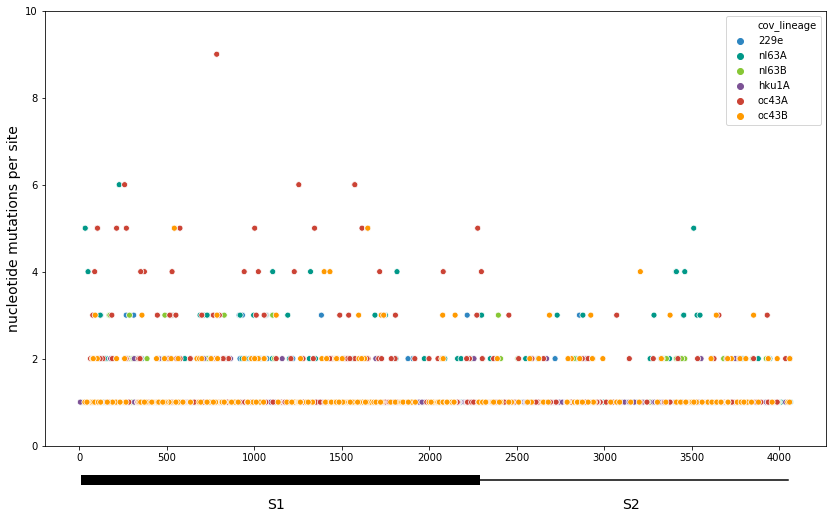

In [12]:
plot_muts_by_pos(['229e', 'nl63', 'hku1', 'oc43'], 'spike', 'nt')

In [22]:
def plot_muts_by_pos(covs, kind, filename=None):
    
    to_plot = []
    
    for cov in covs:
        if cov == '229e':
            muts_count, sites_count, s1_muts_per_window, s2_muts_per_window = count_muts_by_site(cov, kind)
            for site, count in sites_count.items():
                to_plot.append({'cov' : cov, 'cov_lineage' : cov, 'position': int(site), 
                                'count': int(count), 'type_of_mut': kind})
        else:
            lineages = ['A', 'B']
            for lineage in lineages:
                muts_count, sites_count, s1_muts_per_window, s2_muts_per_window = count_muts_by_site(cov, kind, lineage=lineage)
                for site, count in sites_count.items():
                    to_plot.append({'cov' : cov, 'cov_lineage' : cov+lineage, 'position': int(site), 
                                    'count': int(count), 'type_of_mut': kind})
    
    to_plot_df = pd.DataFrame(to_plot)
    
    color_map = {'oc43A': '#CB4335', 'oc43B':'#FF9A00',  '229e': '#2E86C1', 
                 'nl63A': '#009888', 'nl63B': '#87C735', 'hku1A': '#7c5295', 'hku1B': '#b491c8'}    
    
    fig, ax = plt.subplots(figsize=(14,8))
    
    ax = sns.pointplot(x="position", y="count", hue='cov_lineage', data=to_plot_df, join=False)
    ax.set_ylim([0, (to_plot_df['count'].max()+1)])
    plt.ylabel('amino acid substitutions per site', fontsize=14)
    if kind == 'nt':
        plt.ylabel('nucleotide mutations per site', fontsize=14)
    plt.xlabel('')
    
#     s1_start = 14
#     s1_mid = 375
#     s2_mid = 1051
#     s1_end = 766
#     s2_end = 1349
#     if kind == 'nt':
#         s1_start, s1_mid, s2_mid, s1_end, s2_end = s1_start*3-2, s1_mid*3, s2_mid*3, s1_end*3, s2_end*3
    
#     trans = ax.get_xaxis_transform()
#     ax.annotate('S1', xy=(s1_mid, -.12), fontsize=14, xycoords=trans, ha="center", va="top")
#     ax.annotate('S2', xy=(s2_mid, -.12), fontsize=14, xycoords=trans, ha="center", va="top")
#     ax.plot([s1_start,s1_end],[-.08,-.08], color="k", linewidth=10, transform=trans, clip_on=False)
#     ax.plot([s1_end+1,s2_end],[-.08,-.08], color="k", transform=trans, clip_on=False)

    if filename:
        fig.savefig(filename, dpi=300)